In [1]:
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpl9xuxvwx
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


'/root/.cmdstan/cmdstan-2.31.0'

In [64]:
import pandas as pd
data = pd.read_csv("/content/viaggi_individui_2014_2021.csv")

mask = data.annrif != 2014
mask2 = data.annrif != 2015
mask3 = data.annrif != 2016
mask4 = data.annrif != 2018
mask5 = data.annrif != 2020
res = mask * mask2 * mask3 * mask4 * mask5 
data1 = data[res].drop("Unnamed: 0",axis = 1).fillna(-1)
data = data1

print(data.shape)

from sklearn.preprocessing import OneHotEncoder

(147721, 25)


In [65]:

data_2 = data[data.annrif == 2019]
m = data_2.DURATA > 0
data_2_trav = data_2[m]
print(data_2_trav.shape)
data_2_notrav = data_2[~m]
print(data_2_notrav.shape)
data_2_trav = data_2_trav.sample(n=1300, random_state=1)
data_2_notrav = data_2_notrav.sample(n=1300, random_state=1)
print(data_2_trav.shape)
print(data_2_notrav.shape)

data_3 = data[data.annrif == 2021]
m = data_3.DURATA > 0
data_3_trav = data_3[m]
print(data_3_trav.shape)
data_3_notrav = data_3[~m]
print(data_3_notrav.shape)
data_3_trav = data_3_trav.sample(n=1300, random_state=1)
data_3_notrav = data_3_notrav.sample(n=1300, random_state=1)
print(data_3_trav.shape)
print(data_3_notrav.shape)

#data_ = pd.concat([data_1_trav,data_1_notrav,data_2_trav,data_2_notrav,data_3_trav,data_3_notrav])
data_ = pd.concat([data_2_trav,data_2_notrav,data_3_trav,data_3_notrav])
data = data_

(4393, 25)
(38801, 25)
(1300, 25)
(1300, 25)
(4284, 25)
(60602, 25)
(1300, 25)
(1300, 25)


In [66]:
df = pd.DataFrame()

In [67]:
# civil state
name = "staciv4"
cols = ["married","divorced","widowed"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [68]:

# region of origin
name = "rip"
cols = ["North-East","Center","South","Islands"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [69]:
# education level
name = "istr4"
cols = ["middle school","high school","university"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [70]:
# type of travel
name = "TIPOVGG"
cols = ["vacation trip"]

enc = OneHotEncoder()
or_val = data[name].astype(str)
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
df_temp = pd.DataFrame(t_val)
df_temp = df_temp.loc[:,2:]
df_temp.columns = cols

df[cols] = df_temp

In [42]:
## model stan, probability mixture model

model_stan_mixture =  """


data {

      // number of samples
      int<lower=0> n_samples;
      // number of covariates for f1 / number of columns of X
      int<lower=0> p1;
      // number of covariates for lambda, theta, prob_inflated / number of columns of Z
      int<lower=0> p2;
      // number of mixture terms in model 
      int<lower=1> M;

      // samples
      int<lower=0> y[n_samples];
      // covariates for the simplex prob
      matrix[n_samples,p1] X;
      // covariates for poisson prob
      matrix[n_samples,p2] Z;
      // inflated values
      int shifts[M];

    }

    parameters {
      matrix[M,p1] beta_poisson_raw;
      matrix[M,p2] beta_simplex_raw;
    }

    transformed parameters {

      matrix[M,p1] beta_poisson = 1*beta_poisson_raw;
      matrix[M,p2] beta_simplex = 1*beta_simplex_raw;

      //computation for Poisson parameter
      matrix[n_samples,M] lambda;
      lambda = exp(X*beta_poisson'); 
      
      // computation of ratio probabilities. Try simplex distributions somehow?

      matrix<lower=0, upper=1>[n_samples,M] ratio_prob;
      ratio_prob = Z*beta_simplex';
      for(i in 1:n_samples) {
        ratio_prob[i] = softmax(ratio_prob[i]')';
        real accumulation = 0;
        for (k in 1:M) {
          accumulation += ratio_prob[i,k]*(y[i] >= shifts[k]);
        }
        for (k in 1:M) {
          ratio_prob[i,k] = min([1,ratio_prob[i,k]/accumulation]);
        }
      }
    }

    model {
      for (i in 1:M) {
        beta_poisson_raw[i] ~ std_normal();
        beta_simplex_raw[i] ~ std_normal();
      }

      matrix[n_samples,M] log_ratio_prob = log(ratio_prob); // cache log calculation
      matrix[n_samples,M] lps = log_ratio_prob;

      for (n in 1:n_samples) {
        for (k in 1:M) {
          if (y[n] >= shifts[k]) {
            lps[n,k] += poisson_lpmf( y[n] - shifts[k] | lambda[n,k] );
          }
        }
      }

      for (n in 1:n_samples) {
        row_vector[M] tmp = lps[n];
        tmp = exp(tmp);
        real summation = 0;
        for (k in 1:M) {
          if (y[n] >= shifts[k]) {
            summation += tmp[k];
          }
        }
        target += log(summation);
      }
    }

    generated quantities  {

      matrix[n_samples,M] log_ratio_prob = log(ratio_prob); // cache log calculation
      matrix[n_samples,M] lps = log_ratio_prob;

      for (n in 1:n_samples) {
        for (k in 1:M) {
          if (y[n] >= shifts[k]) {
            lps[n,k] += poisson_lpmf( y[n] - shifts[k] | lambda[n,k] );
          }
        }
      }

      // log likelihood for model comparison      
      vector[n_samples] log_lik;
      for (i in 1:n_samples) {
        row_vector[M] tmp = lps[i];
        tmp = exp(tmp);
        real summation = 0;
        for (k in 1:M) {
          if (y[i] >= shifts[k]) {
            summation += tmp[k];
          }
        }
        log_lik[i] = log(summation);
      }

    }



"""

In [43]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_mixture, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /content/full_test
13:18:55 - cmdstanpy - INFO - compiling stan file /content/full_test.stan to exe file /content/full_test
INFO:cmdstanpy:compiling stan file /content/full_test.stan to exe file /content/full_test
DEBUG:cmdstanpy:cmd: make /content/full_test
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/full_test.hpp /content/full_test.stan
Warning in '/content/full_test.stan', line 16, column 6: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/content/full_test.stan', line 22, column 6: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be c

In [11]:

# consider passing "auto-format" flag to stanc to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    # max_line_length = 78,
    backup = False
)

In [12]:


data.loc[data["DURATA"] == -1,"DURATA"] = 0
Y = np.array(data["DURATA"],dtype = int)
X = df
print(X.columns)
X = np.column_stack([np.ones_like(Y), X])
print(Y.shape)
print(X.shape)
print(sum(np.isnan(X)))

Index(['married', 'divorced', 'widowed', 'North-East', 'Center', 'South',
       'Islands', 'middle school', 'high school', 'university',
       'vacation trip'],
      dtype='object')
(5200,)
(5200, 12)
[0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:


Y = np.array(data["DURATA"],dtype = int)
Z = df
Z = np.column_stack([np.ones_like(Y), Z])
print(X.shape)
print(Y.shape)
print(Z.shape)

(5200, 12)
(5200,)
(5200, 12)


In [22]:
stan_data = {
    "n_samples": len(Y),
    "p1": X.shape[1],
    "p2": Z.shape[1],
    "M": 8,
    "y": Y,
    "X": X,
    "Z": Z,
    "shifts": [0,2,7,10,14,15,20,30]
}

In [50]:
stan_test_fit = stan_model.sample(data=stan_data, chains=1, parallel_chains=1, 
                             iter_warmup=2000, iter_sampling=2000,
                             #adapt_delta=0.7,
                             #step_size = 0.5,
                             #max_treedepth=15,
                             refresh=10,
                             inits  = 0,
                             show_console=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjtlydvs2/ugkuc6dd.json
DEBUG:cmdstanpy:cmd: /content/full_test info
cwd: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/full_test', 'id=1', 'random', 'seed=43869', 'data', 'file=/tmp/tmpjtlydvs2/ugkuc6dd.json', 'init=0', 'output', 'file=/tmp/tmpjtlydvs2/full_test10fhduq3/full_test-20230213133706.csv', 'refresh=10', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
13:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 2000
Chain [1] num_warmup = 2000
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpjtlydvs2/ugkuc6dd.json
Chain [1] init = 0
Chain [1] random
Chain [1] seed = 43869
Chain [1] output
Chain [1] file = /tmp/tmpjtlydvs2/

14:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/full_test', 'id=1', 'random', 'seed=43869', 'data', 'file=/tmp/tmpjtlydvs2/ugkuc6dd.json', 'init=0', 'output', 'file=/tmp/tmpjtlydvs2/full_test10fhduq3/full_test-20230213133706.csv', 'refresh=10', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpjtlydvs2/full_test10fhduq3/full_test-20230213133706.csv
 console_msgs (if any):
	/tmp/tmpjtlydvs2/full_test10fhduq3/full_test-20230213133706_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 2000
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.8000000000

Chain [1] 
Chain [1] Elapsed Time: 1118.33 seconds (Warm-up)
Chain [1] 1456.82 seconds (Sampling)
Chain [1] 2575.15 seconds (Total)
Chain [1] 
Chain [1] 


/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (96), generating only 20 plots
  warnings.warn(


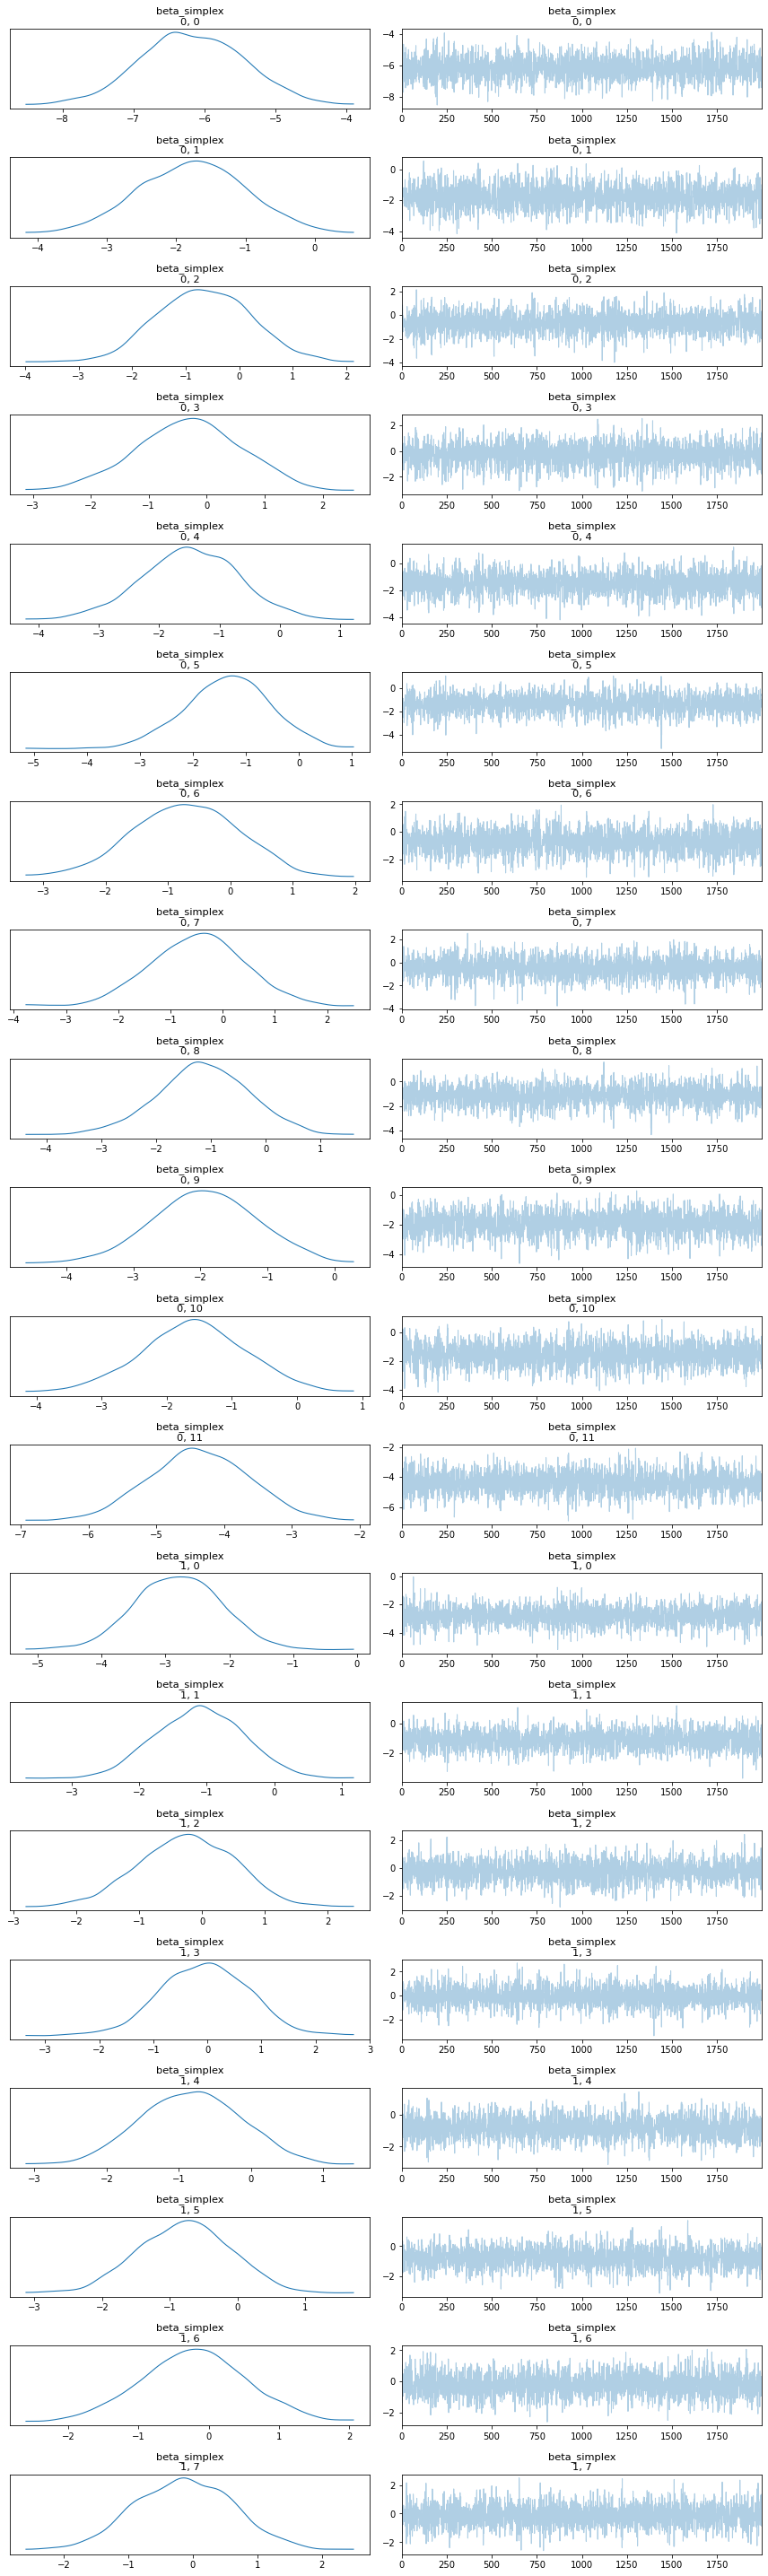

In [51]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)
az.plot_trace(cmdstanpy_data,var_names=["beta_simplex"], compact=False)
plt.tight_layout()
plt.show()

In [52]:
print("Poisson Mixture model WAIC: ", az.waic(cmdstanpy_data,var_name="log_lik"))

Poisson Mixture model WAIC:  Computed from 2000 posterior samples and 5200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3842.51    71.87
p_waic      106.13        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [53]:
stacked = az.hdi(cmdstanpy_data, hdi_prob = 0.95)
inflated = [0,2,7,10,14,15,20,30]

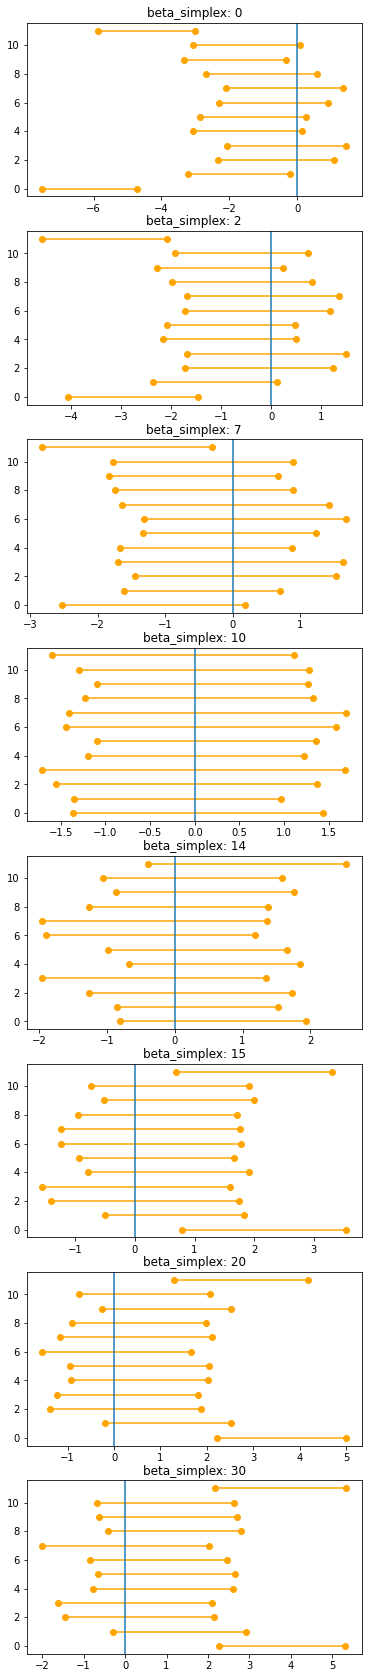

In [54]:


# inflated values
stacked_np = stacked['beta_simplex'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_simplex: {}".format(inflated[i]))
     


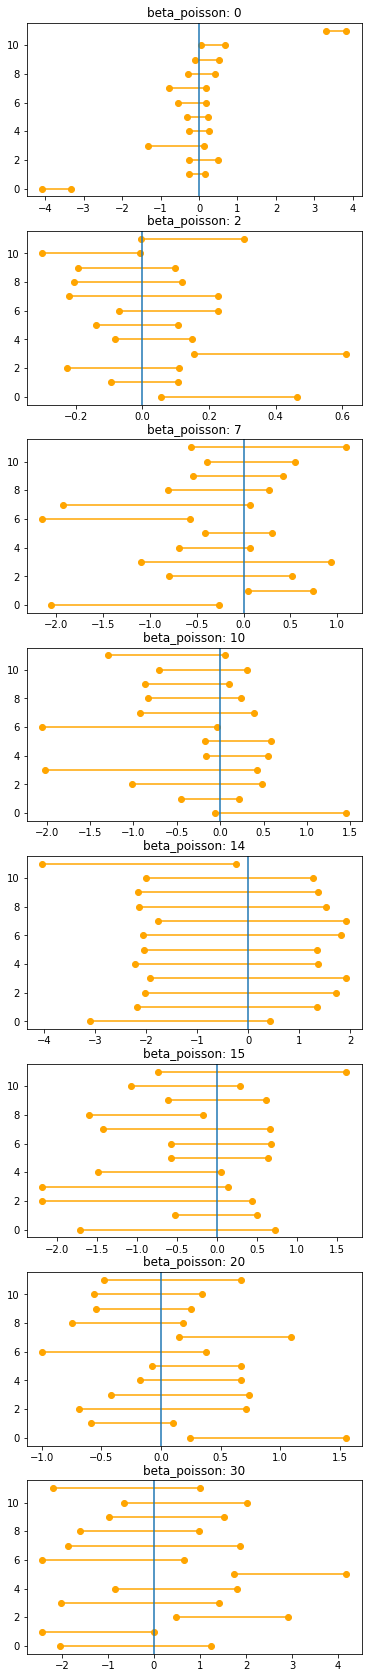

In [55]:
# inflated values
stacked_np = stacked['beta_poisson'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_poisson: {}".format(inflated[i]))

## Two years comparison

In [79]:
data = pd.read_csv("/content/viaggi_individui_2014_2021.csv")

mask = data.annrif != 2014
mask2 = data.annrif != 2015
mask3 = data.annrif != 2016
mask4 = data.annrif != 2018
mask5 = data.annrif != 2020
res = mask * mask2 * mask3 * mask4 * mask5 
data1 = data[res].drop("Unnamed: 0",axis = 1).fillna(-1)
data = data1

In [80]:

data_2 = data[data.annrif == 2019]
m = data_2.DURATA > 0
data_2_trav = data_2[m]
print(data_2_trav.shape)
data_2_notrav = data_2[~m]
print(data_2_notrav.shape)
data_2_trav = data_2_trav.sample(n=1300, random_state=1)
data_2_notrav = data_2_notrav.sample(n=1300, random_state=1)
print(data_2_trav.shape)
print(data_2_notrav.shape)

data_3 = data[data.annrif == 2021]
m = data_3.DURATA > 0
data_3_trav = data_3[m]
print(data_3_trav.shape)
data_3_notrav = data_3[~m]
print(data_3_notrav.shape)
data_3_trav = data_3_trav.sample(n=1300, random_state=1)
data_3_notrav = data_3_notrav.sample(n=1300, random_state=1)
print(data_3_trav.shape)
print(data_3_notrav.shape)

#data_ = pd.concat([data_1_trav,data_1_notrav,data_2_trav,data_2_notrav,data_3_trav,data_3_notrav])
data1 = pd.concat([data_2_trav,data_2_notrav])
data2 = pd.concat([data_3_trav,data_3_notrav])


(4393, 25)
(38801, 25)
(1300, 25)
(1300, 25)
(4284, 25)
(60602, 25)
(1300, 25)
(1300, 25)


In [81]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [82]:
# civil state
name = "staciv4"
cols = ["married","divorced","widowed"]

enc = OneHotEncoder()
or_val = data1[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df1[cols] = df_temp

enc = OneHotEncoder()
or_val = data2[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df2[cols] = df_temp

In [83]:
# region of origin
name = "rip"
cols = ["North-East","Center","South","Islands"]

enc = OneHotEncoder()
or_val = data1[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df1[cols] = df_temp

or_val = data2[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df2[cols] = df_temp

In [84]:
# education level
name = "istr4"
cols = ["middle school","high school","university"]

enc = OneHotEncoder()
or_val = data1[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df1[cols] = df_temp

or_val = data2[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df2[cols] = df_temp

In [85]:
# type of travel
name = "TIPOVGG"
cols = ["vacation trip"]

enc = OneHotEncoder()
or_val = data1[name].astype(str)
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
df_temp = pd.DataFrame(t_val)
df_temp = df_temp.loc[:,2:]
df_temp.columns = cols

df1[cols] = df_temp

or_val = data2[name].astype(str)
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
df_temp = pd.DataFrame(t_val)
df_temp = df_temp.loc[:,2:]
df_temp.columns = cols

df2[cols] = df_temp

In [88]:
data1.loc[data1["DURATA"] == -1,"DURATA"] = 0
Y1 = np.array(data1["DURATA"],dtype = int)
X1 = df1
print(X1.columns)
X1 = np.column_stack([np.ones_like(Y1), X1])
print(Y1.shape)
print(X1.shape)
print(sum(np.isnan(X1)))

data2.loc[data2["DURATA"] == -1,"DURATA"] = 0
Y2 = np.array(data2["DURATA"],dtype = int)
X2 = df2
print(X2.columns)
X2 = np.column_stack([np.ones_like(Y2), X2])
print(Y2.shape)
print(X2.shape)
print(sum(np.isnan(X2)))

Index(['married', 'divorced', 'widowed', 'North-East', 'Center', 'South',
       'Islands', 'middle school', 'high school', 'university',
       'vacation trip'],
      dtype='object')
(2600,)
(2600, 12)
[0 0 0 0 0 0 0 0 0 0 0 0]
Index(['married', 'divorced', 'widowed', 'North-East', 'Center', 'South',
       'Islands', 'middle school', 'high school', 'university',
       'vacation trip'],
      dtype='object')
(2600,)
(2600, 12)
[0 0 0 0 0 0 0 0 0 0 0 0]


In [89]:
Y1 = np.array(data1["DURATA"],dtype = int)
Z1 = df1
Z1 = np.column_stack([np.ones_like(Y1), Z1])
print(X1.shape)
print(Y1.shape)
print(Z1.shape)

Y2 = np.array(data2["DURATA"],dtype = int)
Z2 = df2
Z2 = np.column_stack([np.ones_like(Y2), Z2])
print(X2.shape)
print(Y2.shape)
print(Z2.shape)

(2600, 12)
(2600,)
(2600, 12)
(2600, 12)
(2600,)
(2600, 12)


In [96]:
## model stan, probability mixture model

model_stan_mixture =  """


data {

      // number of samples
      int<lower=0> n_samples_1;
      int<lower=0> n_samples_2;
      // number of covariates for f1 / number of columns of X
      int<lower=0> p1;
      // number of covariates for lambda, theta, prob_inflated / number of columns of Z
      int<lower=0> p2;
      // number of mixture terms in model 
      int<lower=1> M;

      // samples
      int<lower=0> y1[n_samples_1];
      int<lower=0> y2[n_samples_2];
      // covariates for the simplex prob
      matrix[n_samples_1,p1] X1;
      matrix[n_samples_2,p1] X2;
      // covariates for poisson prob
      matrix[n_samples_1,p2] Z1;
      matrix[n_samples_2,p2] Z2;
      // inflated values
      int shifts[M];

    }

    parameters {
      matrix[M,p1] beta_poisson_raw1;
      matrix[M,p2] beta_simplex_raw1;
      matrix[M,p1] beta_poisson_raw2;
      matrix[M,p2] beta_simplex_raw2;
    }

    transformed parameters {

      matrix[M,p1] beta_poisson1 = 1*beta_poisson_raw1;
      matrix[M,p2] beta_simplex1 = 1*beta_simplex_raw1;
      matrix[M,p1] beta_poisson2 = 1*beta_poisson_raw2;
      matrix[M,p2] beta_simplex2 = 1*beta_simplex_raw2;

      //computation for Poisson parameter
      matrix[n_samples_1,M] lambda1;
      matrix[n_samples_2,M] lambda2;
      lambda1 = exp(X1*beta_poisson1'); 
      lambda2 = exp(X2*beta_poisson2'); 
      
      // computation of ratio probabilities. Try simplex distributions somehow?

      matrix<lower=0, upper=1>[n_samples_1,M] ratio_prob1;
      ratio_prob1 = Z1*beta_simplex1';
      for(i in 1:n_samples_1) {
        ratio_prob1[i] = softmax(ratio_prob1[i]')';
        real accumulation = 0;
        for (k in 1:M) {
          accumulation += ratio_prob1[i,k]*(y1[i] >= shifts[k]);
        }
        for (k in 1:M) {
          ratio_prob1[i,k] = min([1,ratio_prob1[i,k]/accumulation]);
        }
      }

      matrix<lower=0, upper=1>[n_samples_2,M] ratio_prob2;
      ratio_prob2 = Z2*beta_simplex2';
      for(i in 1:n_samples_2) {
        ratio_prob2[i] = softmax(ratio_prob2[i]')';
        real accumulation = 0;
        for (k in 1:M) {
          accumulation += ratio_prob2[i,k]*(y2[i] >= shifts[k]);
        }
        for (k in 1:M) {
          ratio_prob2[i,k] = min([1,ratio_prob2[i,k]/accumulation]);
        }
      }
    }

    model {
      for (i in 1:M) {
        beta_poisson_raw1[i] ~ std_normal();
        beta_simplex_raw1[i] ~ std_normal();
        beta_poisson_raw2[i] ~ std_normal();
        beta_simplex_raw2[i] ~ std_normal();
      }

      matrix[n_samples_1,M] log_ratio_prob1 = log(ratio_prob1); // cache log calculation
      matrix[n_samples_1,M] lps1 = log_ratio_prob1;
      matrix[n_samples_2,M] log_ratio_prob2 = log(ratio_prob2); // cache log calculation
      matrix[n_samples_2,M] lps2 = log_ratio_prob2;

      for (n in 1:n_samples_1) {
        for (k in 1:M) {
          if (y1[n] >= shifts[k]) {
            lps1[n,k] += poisson_lpmf( y1[n] - shifts[k] | lambda1[n,k] );
          }
        }
      }

      for (n in 1:n_samples_2) {
        for (k in 1:M) {
          if (y2[n] >= shifts[k]) {
            lps2[n,k] += poisson_lpmf( y2[n] - shifts[k] | lambda2[n,k] );
          }
        }
      }

      for (n in 1:n_samples_1) {
        row_vector[M] tmp = lps1[n];
        tmp = exp(tmp);
        real summation = 0;
        for (k in 1:M) {
          if (y1[n] >= shifts[k]) {
            summation += tmp[k];
          }
        }
        target += log(summation);
      }

      for (n in 1:n_samples_2) {
        row_vector[M] tmp = lps2[n];
        tmp = exp(tmp);
        real summation = 0;
        for (k in 1:M) {
          if (y2[n] >= shifts[k]) {
            summation += tmp[k];
          }
        }
        target += log(summation);
      }
    }



"""

In [97]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_mixture, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /content/full_test
15:59:47 - cmdstanpy - INFO - compiling stan file /content/full_test.stan to exe file /content/full_test
INFO:cmdstanpy:compiling stan file /content/full_test.stan to exe file /content/full_test
DEBUG:cmdstanpy:cmd: make /content/full_test
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/full_test.hpp /content/full_test.stan
Warning in '/content/full_test.stan', line 17, column 6: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/content/full_test.stan', line 18, column 6: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be c

In [98]:

# consider passing "auto-format" flag to stanc to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    # max_line_length = 78,
    backup = False
)

In [101]:
stan_data = {
    "n_samples_1": len(Y1),
    "n_samples_2": len(Y2),
    "p1": X1.shape[1],
    "p2": Z1.shape[1],
    "M": 8,
    "y1": Y1,
    "y2": Y2,
    "X1": X1,
    "X2": X2,
    "Z1": Z1,
    "Z2": Z2,
    "shifts": [0,2,7,10,14,15,20,30]
}

In [110]:
stan_test_fit = stan_model.sample(data=stan_data, chains=1, parallel_chains=1, 
                             iter_warmup=2000, iter_sampling=2000,
                             #adapt_delta=0.7,
                             #step_size = 0.5,
                             #max_treedepth=15,
                             refresh=10,
                             inits  = 0,
                             show_console=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjtlydvs2/5am_28sv.json
DEBUG:cmdstanpy:cmd: /content/full_test info
cwd: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/full_test', 'id=1', 'random', 'seed=254', 'data', 'file=/tmp/tmpjtlydvs2/5am_28sv.json', 'init=0', 'output', 'file=/tmp/tmpjtlydvs2/full_testfraoewbj/full_test-20230213161136.csv', 'refresh=10', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
16:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 2000
Chain [1] num_warmup = 2000
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpjtlydvs2/5am_28sv.json
Chain [1] init = 0
Chain [1] random
Chain [1] seed = 254
Chain [1] output
Chain [1] file = /tmp/tmpjtlydvs2/fu

16:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/full_test', 'id=1', 'random', 'seed=254', 'data', 'file=/tmp/tmpjtlydvs2/5am_28sv.json', 'init=0', 'output', 'file=/tmp/tmpjtlydvs2/full_testfraoewbj/full_test-20230213161136.csv', 'refresh=10', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpjtlydvs2/full_testfraoewbj/full_test-20230213161136.csv
 console_msgs (if any):
	/tmp/tmpjtlydvs2/full_testfraoewbj/full_test-20230213161136_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 2000
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000000

Chain [1] 
Chain [1] Elapsed Time: 1220.87 seconds (Warm-up)
Chain [1] 1362.23 seconds (Sampling)
Chain [1] 2583.1 seconds (Total)
Chain [1] 
Chain [1] 


/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (96), generating only 20 plots
  warnings.warn(


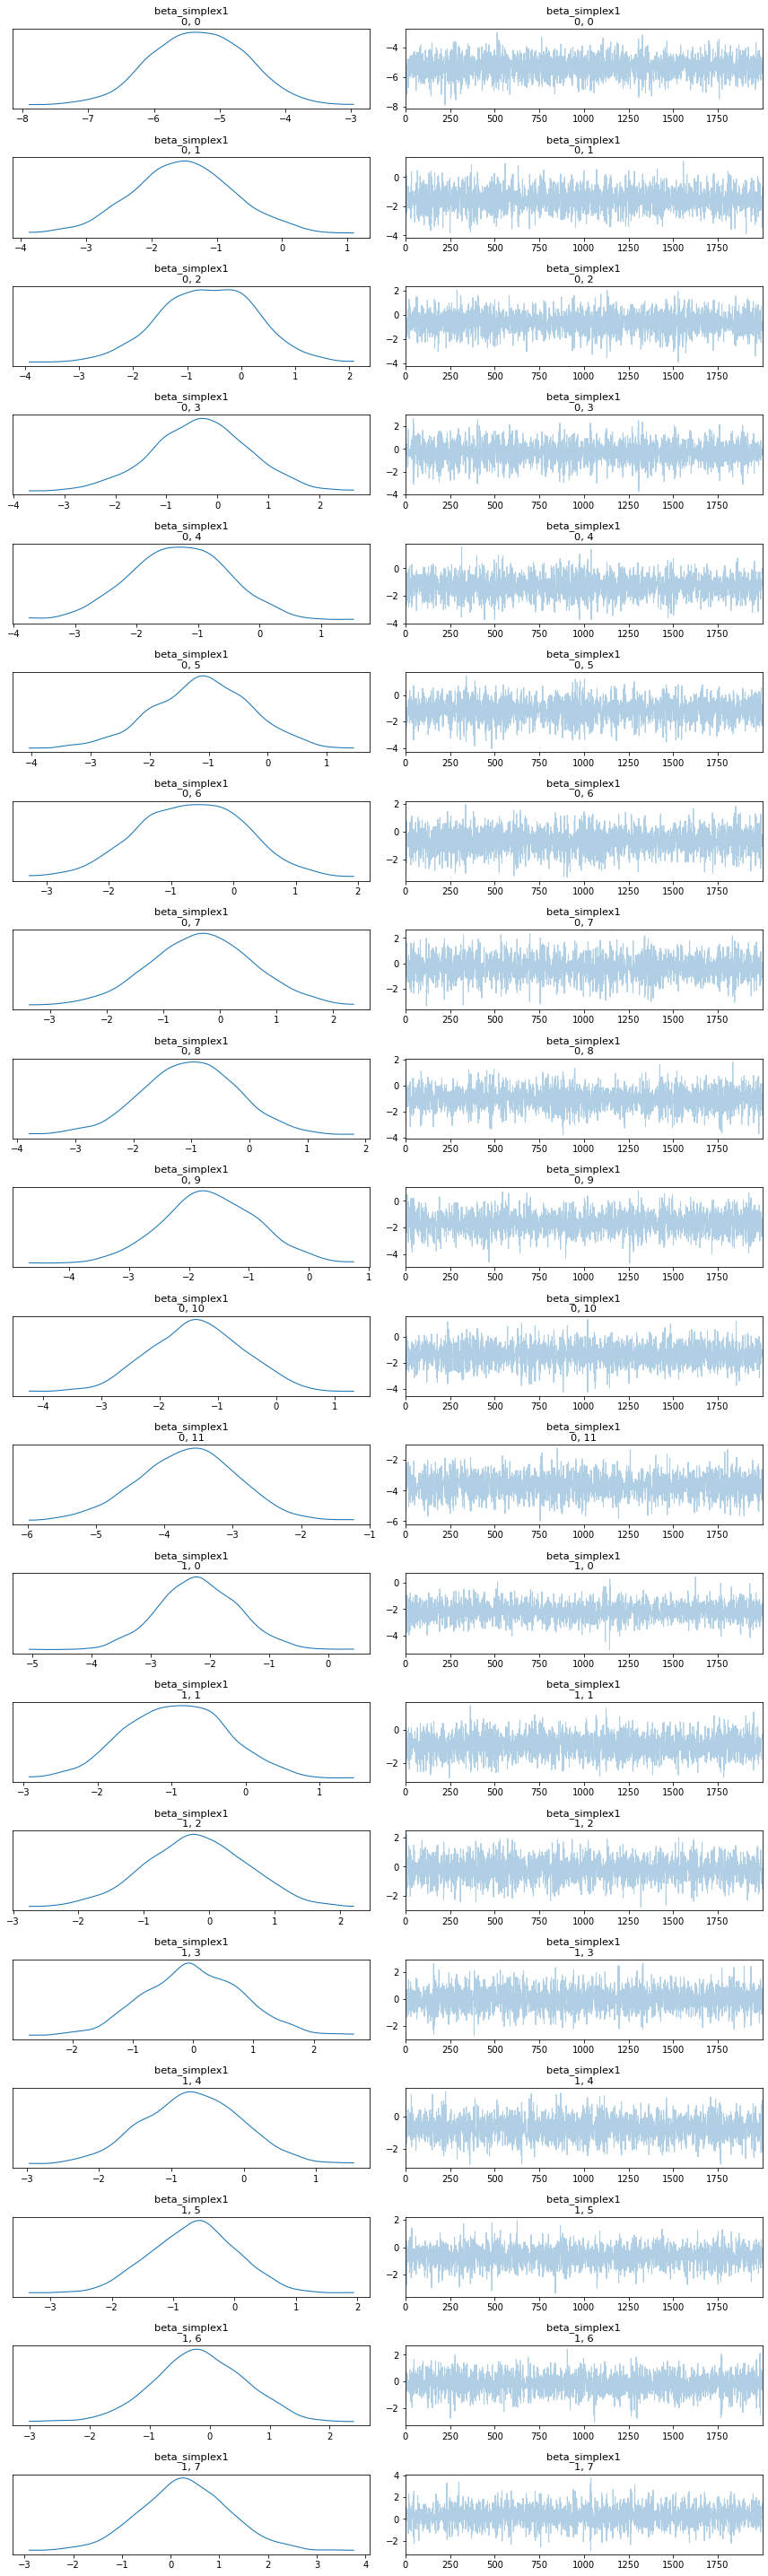

In [111]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)
az.plot_trace(cmdstanpy_data,var_names=["beta_simplex1"], compact=False)
plt.tight_layout()
plt.show()

In [112]:
stacked = az.hdi(cmdstanpy_data, hdi_prob = 0.95)
inflated = [0,2,7,10,14,15,20,30]

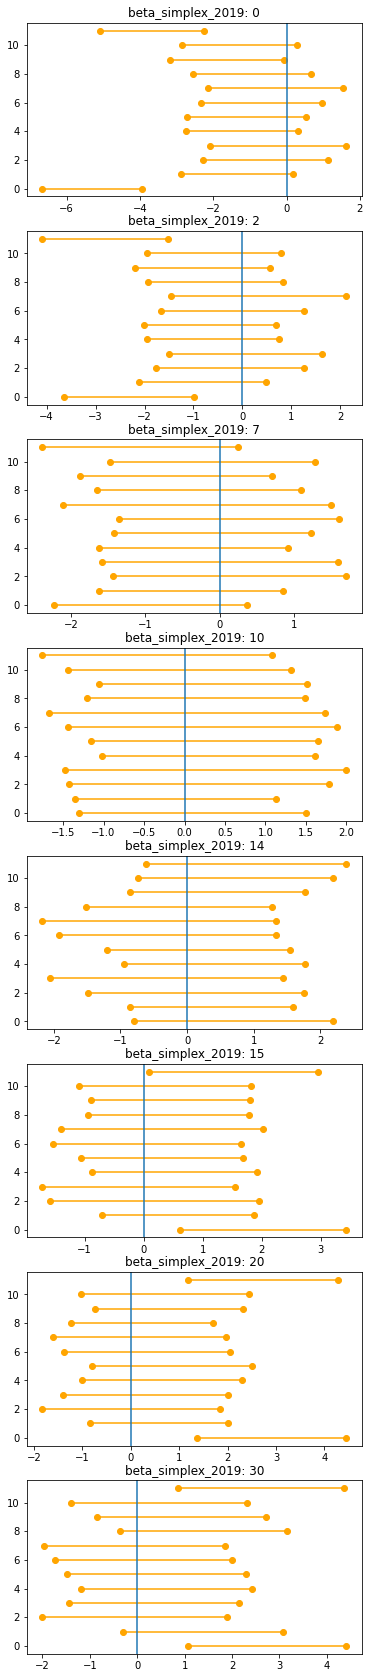

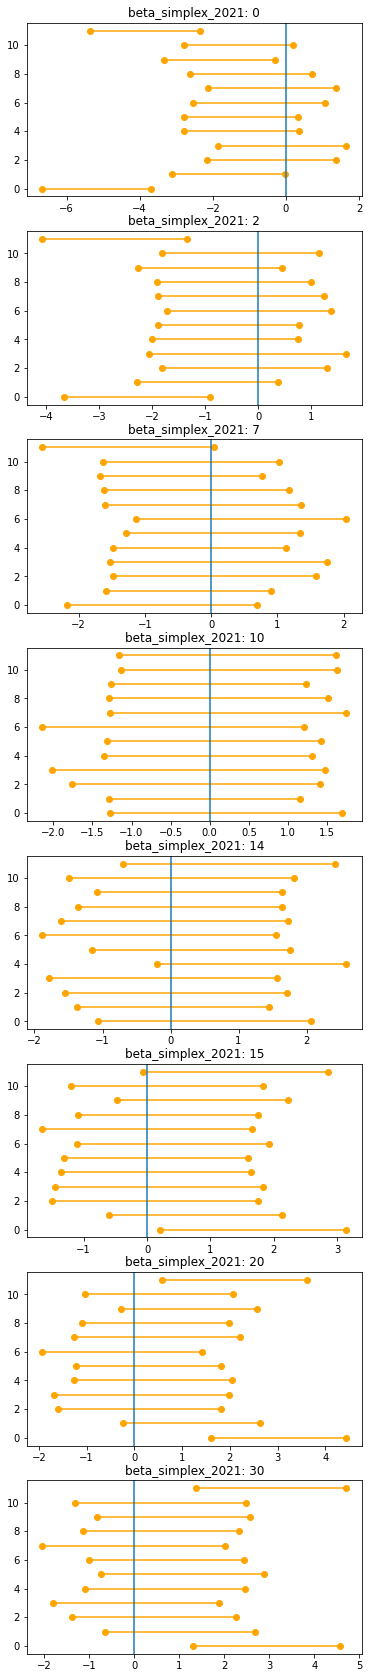

In [113]:
# inflated values
stacked_np = stacked['beta_simplex1'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_simplex_2019: {}".format(inflated[i]))

  # inflated values
stacked_np = stacked['beta_simplex2'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_simplex_2021: {}".format(inflated[i]))

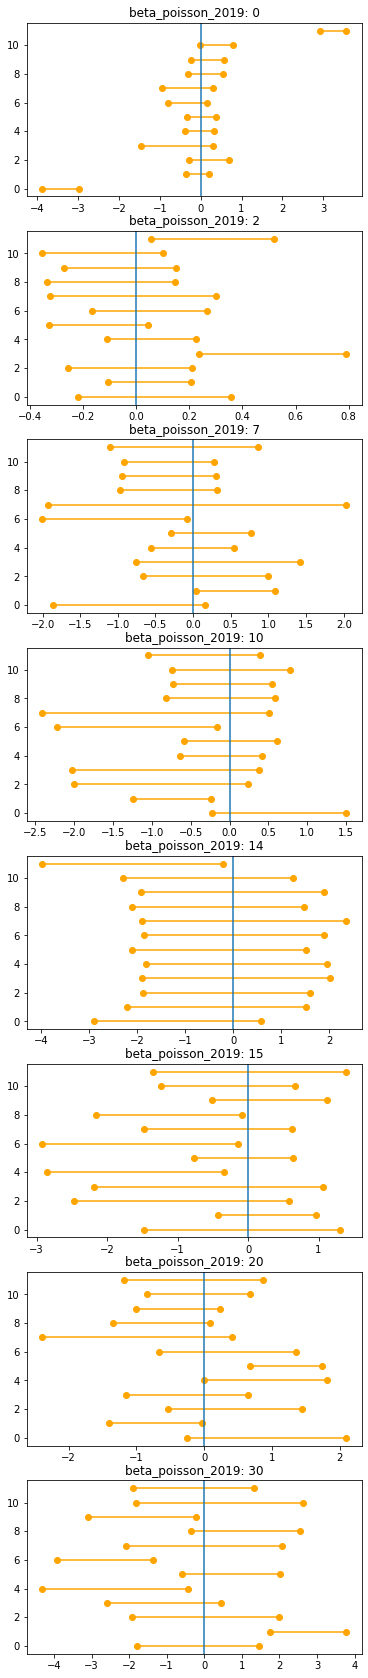

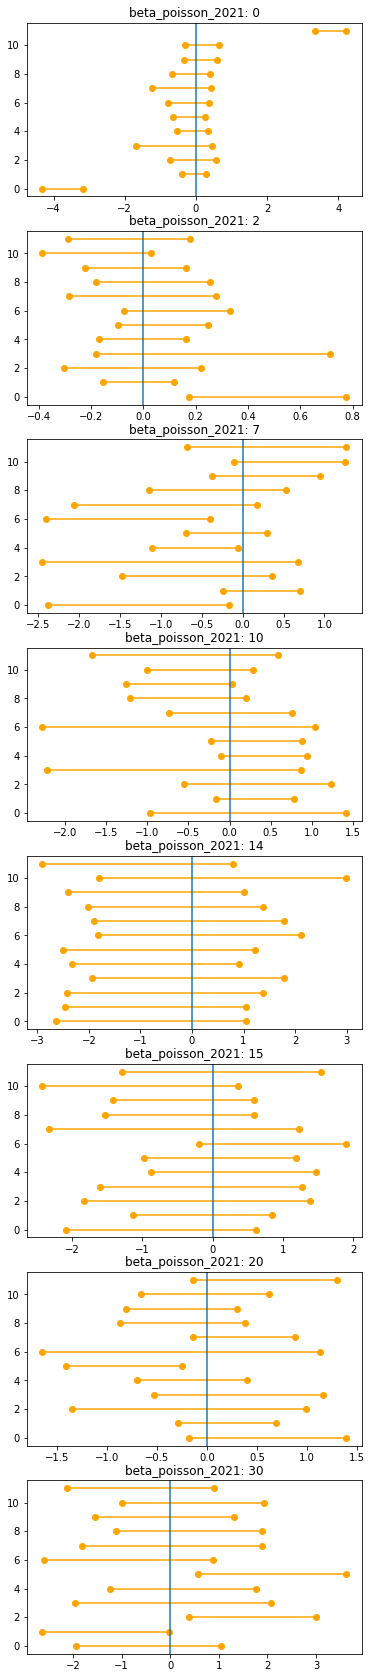

In [114]:
# inflated values
stacked_np = stacked['beta_poisson1'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_poisson_2019: {}".format(inflated[i]))

stacked_np = stacked['beta_poisson2'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("beta_poisson_2021: {}".format(inflated[i]))